<a href="https://colab.research.google.com/github/Oreolorun/Image-Recognition/blob/main/CarTypeImageRegcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
!pip install shap
import shap

In [2]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [4]:
#  loading and labelling data

class LoadVehicleData():
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    self.img_size = 75
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self, rebuild=True):
    if rebuild:
      for key in self.labels:
        print(key)
        for img_file in tqdm(os.listdir(key)):
          try:
            path = os.path.join(key, img_file)
            image = cv2.imread(path)
            image = cv2.resize(image, (self.img_size, self.img_size))
            image = np.array(image)
            self.training_data.append([image, int(self.labels[key])])
            if key == self.sedans:
              self.sedan_count+=1
            elif key == self.coupes:
              self.coupe_count+=1
            elif key == self.suvs:
              self.suv_count+=1
            elif key == self.trucks:
              self.truck_count+=1
          except Exception as e:
            pass
      np.random.shuffle(self.training_data)
      np.save('gdrive/My Drive/Neural Networks/loaded_npy_files/CarType75x75.npy', self.training_data)
      print(f'\nsedan images: {self.sedan_count}')
      print(f'coupe images: {self.coupe_count}')
      print(f'suv images: {self.suv_count}')
      print(f'truck images: {self.truck_count}')
      print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
      print('All done!')
    else:
      print('Rebuild argument set to false, data will be loaded into the dataset object from specified path.\nSet rebuild to true to rebuild dataset.')
      pass

In [5]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
data.create_dataset(rebuild=False)

#  loading dataset into object
dataset = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/CarType100x100.npy', allow_pickle=True)
print('\nDone!')

Rebuild argument set to false, data will be loaded into the dataset object from specified path.
Set rebuild to true to rebuild dataset.

Done!


In [6]:
#  checking dataset
len(dataset)

81332

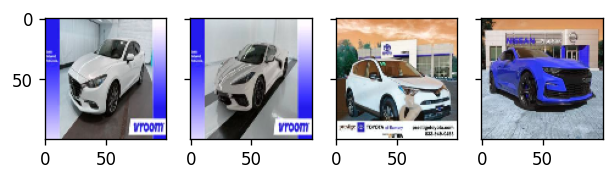

In [ ]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[1].imshow(dataset[1][0])
axes[2].imshow(dataset[23967][0])
axes[3].imshow(dataset[19929][0])

In [7]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
#test_indices, dataset_indices = train_val_split(dataset, 0.1)
#val_indices, train_indices = train_val_split(dataset_indices, 0.2)

#  saving indices for reproducbility
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', train_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', val_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', test_indices)

#  loading saved indices
train_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', allow_pickle=True))
val_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', allow_pickle=True))
test_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', allow_pickle=True))

#  splitting into training, validation and test sets
training_set = dataset[train_indices]
validation_set = dataset[val_indices]
test_set = dataset[test_indices]

In [8]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx][0]/255
    #  extracting label from index
    label = torch.tensor(int(self.loaded_dataset[idx][1]))
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
    return (image, label)

In [9]:
#  creating an instances of the dataset class
train_ds = VehicleDataset(training_set, transforms=transforms.ToTensor())
val_ds = VehicleDataset(validation_set, transforms=transforms.ToTensor())
test_ds = VehicleDataset(test_set, transforms=transforms.ToTensor())

#  creating dataloaders
batch_size = 100
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [10]:
#  building neural network
class CarRecognition(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.conv1(x))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool4(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool7(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [11]:
#  building neural network for 75px images
class CarRecognition_75(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.conv1(x))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool4(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool7(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [12]:
#  building neural network
class CarRecognition_bn(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.batchnorm_fc1(self.fc1(x)))
    x = F.relu(self.batchnorm_fc2(self.fc2(x)))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [13]:
#  building neural network
class CarRecognition_bn75(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.batchnorm_fc1(self.fc1(x)))
    x = F.relu(self.batchnorm_fc2(self.fc2(x)))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [14]:
def accuracy(network, train_loader, verbose=False):
  #  instantiating model state
  network.eval()
  #  creating counter for correctly classified instances
  correctly_classified = 0
  #  creating counter for all instances
  all_instances = 0
  #  looping through every batch
  for images, labels in tqdm_notebook(train_loader):
    images, labels = images.to(device), labels.to(device)
    #  classifying
    outputs = network(images)
    #  deriving the index of model prediction
    predicted_labels = torch.argmax(outputs, dim=1)
    #  comparing and counting the number of correct predictions
    correct_labels = sum(predicted_labels==labels)
    #  counting correct predictions
    correctly_classified+=correct_labels.item()
    #  counting all instances
    all_instances+=len(labels)
  if verbose:
    return print(f'[{correctly_classified}/{all_instances}]\nmodel predicts all instances to {round((correctly_classified/all_instances)*100, 2)}% accuracy')
  else:
    return correctly_classified/all_instances

In [15]:
def train_model(network, epochs, loss_function, opt, train_loader, val_loader):
  #  creating a list to hold metrics
  metric_log = []
  for epoch in range(epochs):
    #  instantiating model state
    network.train()
    #  training
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    total_instances = 0
    for images, labels in tqdm_notebook(train_loader):
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  resetting gradients
      opt.zero_grad()
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      with torch.no_grad():
        #  summing loss
        total_loss+=loss.sum().item()
        #  summing instances
        total_instances+=len(labels)
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()
    #  deriving training accuracy
    with torch.no_grad():
      print('Deriving training accuracy...')
      train_accuracy = accuracy(network, train_loader)
    #  deriving validation loss and accuracy
    with torch.no_grad():
      print('Deriving validation loss...')
      total_val_loss = 0
      total_val_instances = 0
      for val_images, val_labels in tqdm_notebook(val_loader):
        #  sending to device
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        #  classifying
        val_outputs = network(val_images)
        #  computing loss
        val_loss = loss_function(val_outputs, val_labels)
        #  summing val_loss
        total_val_loss+=val_loss.sum().item()
        #  summing total_val_instances
        total_val_instances+=len(val_labels)
      print('Deriving validation accuracy...')
      #  computing accuracy
      val_accuracy = accuracy(network, val_loader)
    #  appending metrics to list
    metric_log.append([epoch+1, total_loss/total_instances, 
                       train_accuracy, total_val_loss/total_val_instances, 
                       val_accuracy])
    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs}'+
          f' Training_loss: {round(total_loss/total_instances, 5)}'+
          f' Training_accuracy: {round(train_accuracy, 5)}'+
          f' Validation_loss: {round(total_val_loss/total_val_instances, 5)}'+ 
          f' Validation_accuracy: {round(val_accuracy, 5)}')
  #  saving metrics
  np.save(f'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-1.npy', metric_log)

In [16]:
#  instantiating model
model = CarRecognition_bn()
model.to(device)

#  instantiating loss function
loss_fn = nn.NLLLoss()

#  instantiating optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
epochs = 30

#  training model
train_model(network=model, epochs=epochs, loss_function=loss_fn, 
            opt=optimizer, train_loader=train_dl, val_loader=val_dl)


Training Epoch 1/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 1/30 Training_loss: 0.00726 Training_accuracy: 0.82652 Validation_loss: 0.00482 Validation_accuracy: 0.80743

Training Epoch 2/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 2/30 Training_loss: 0.00344 Training_accuracy: 0.89976 Validation_loss: 0.00325 Validation_accuracy: 0.86994

Training Epoch 3/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 3/30 Training_loss: 0.00222 Training_accuracy: 0.9508 Validation_loss: 0.00236 Validation_accuracy: 0.91208

Training Epoch 4/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 4/30 Training_loss: 0.00156 Training_accuracy: 0.91849 Validation_loss: 0.00331 Validation_accuracy: 0.87957

Training Epoch 5/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 5/30 Training_loss: 0.00115 Training_accuracy: 0.9839 Validation_loss: 0.00179 Validation_accuracy: 0.93893

Training Epoch 6/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 6/30 Training_loss: 0.00084 Training_accuracy: 0.95898 Validation_loss: 0.00258 Validation_accuracy: 0.91058

Training Epoch 7/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 7/30 Training_loss: 0.00065 Training_accuracy: 0.98531 Validation_loss: 0.00191 Validation_accuracy: 0.93893

Training Epoch 8/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 8/30 Training_loss: 0.00056 Training_accuracy: 0.97871 Validation_loss: 0.00229 Validation_accuracy: 0.92786

Training Epoch 9/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 9/30 Training_loss: 0.0005 Training_accuracy: 0.9937 Validation_loss: 0.00181 Validation_accuracy: 0.94774

Training Epoch 10/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 10/30 Training_loss: 0.00039 Training_accuracy: 0.99004 Validation_loss: 0.00216 Validation_accuracy: 0.94023

Training Epoch 11/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 11/30 Training_loss: 0.00037 Training_accuracy: 0.99259 Validation_loss: 0.00198 Validation_accuracy: 0.94542

Training Epoch 12/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 12/30 Training_loss: 0.00035 Training_accuracy: 0.99295 Validation_loss: 0.00225 Validation_accuracy: 0.9418

Training Epoch 13/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 13/30 Training_loss: 0.0003 Training_accuracy: 0.99218 Validation_loss: 0.00222 Validation_accuracy: 0.9433

Training Epoch 14/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 14/30 Training_loss: 0.0003 Training_accuracy: 0.99372 Validation_loss: 0.00219 Validation_accuracy: 0.94419

Training Epoch 15/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 15/30 Training_loss: 0.00025 Training_accuracy: 0.99413 Validation_loss: 0.00238 Validation_accuracy: 0.94385

Training Epoch 16/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 16/30 Training_loss: 0.00025 Training_accuracy: 0.99355 Validation_loss: 0.00233 Validation_accuracy: 0.94166

Training Epoch 17/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 17/30 Training_loss: 0.00023 Training_accuracy: 0.99566 Validation_loss: 0.0022 Validation_accuracy: 0.94781

Training Epoch 18/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 18/30 Training_loss: 0.00021 Training_accuracy: 0.99423 Validation_loss: 0.00233 Validation_accuracy: 0.94528

Training Epoch 19/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 19/30 Training_loss: 0.0002 Training_accuracy: 0.99705 Validation_loss: 0.0021 Validation_accuracy: 0.94849

Training Epoch 20/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 20/30 Training_loss: 0.00018 Training_accuracy: 0.99761 Validation_loss: 0.00202 Validation_accuracy: 0.94925

Training Epoch 21/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 21/30 Training_loss: 0.00018 Training_accuracy: 0.99459 Validation_loss: 0.00234 Validation_accuracy: 0.94487

Training Epoch 22/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 22/30 Training_loss: 0.00018 Training_accuracy: 0.99585 Validation_loss: 0.00205 Validation_accuracy: 0.95218

Training Epoch 23/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 23/30 Training_loss: 0.00017 Training_accuracy: 0.99635 Validation_loss: 0.00215 Validation_accuracy: 0.94822

Training Epoch 24/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 24/30 Training_loss: 0.00015 Training_accuracy: 0.99703 Validation_loss: 0.00213 Validation_accuracy: 0.94945

Training Epoch 25/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 25/30 Training_loss: 0.00015 Training_accuracy: 0.99752 Validation_loss: 0.00228 Validation_accuracy: 0.94979

Training Epoch 26/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 26/30 Training_loss: 0.00015 Training_accuracy: 0.99769 Validation_loss: 0.00229 Validation_accuracy: 0.9487

Training Epoch 27/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 27/30 Training_loss: 0.00013 Training_accuracy: 0.99805 Validation_loss: 0.00239 Validation_accuracy: 0.94918

Training Epoch 28/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 28/30 Training_loss: 0.00013 Training_accuracy: 0.9979 Validation_loss: 0.00253 Validation_accuracy: 0.94911

Training Epoch 29/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 29/30 Training_loss: 0.00012 Training_accuracy: 0.99751 Validation_loss: 0.00226 Validation_accuracy: 0.95061

Training Epoch 30/30


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 30/30 Training_loss: 0.00012 Training_accuracy: 0.99785 Validation_loss: 0.00254 Validation_accuracy: 0.94911


In [ ]:
#  saving model state
#torch.save(model.state_dict(), f'gdrive/My Drive/Neural Networks/Model_States/CarType100x100_model_state_completed_6ep.pt')

In [3]:
metrics_75x75_bn1 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_bn_30epochs.npy', allow_pickle=True)
metrics_75x75_bn2 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_bn_30epochs_1e-2.npy', allow_pickle=True)
metrics_75x75 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_30epochs.npy', allow_pickle=True)

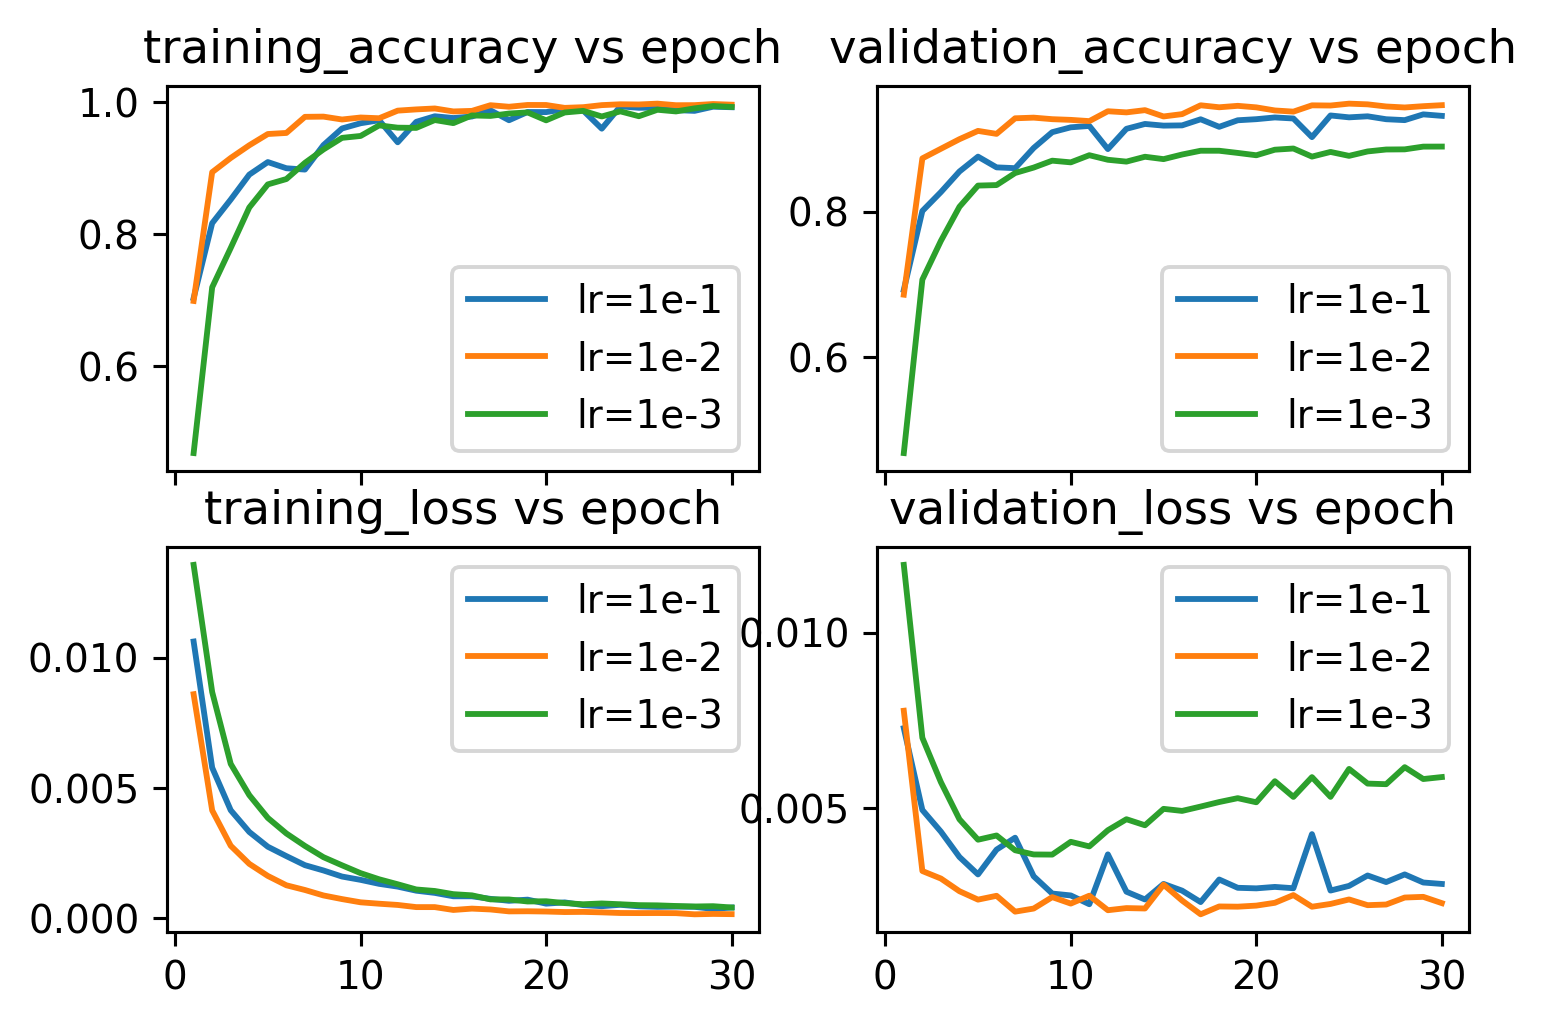

In [6]:
#  visualising metrics
figure, axes = plt.subplots(2,2, dpi=280, sharex=True)
axes[0,0].set_title('training_accuracy vs epoch')
axes[0,1].set_title('validation_accuracy vs epoch')
axes[1,0].set_title('training_loss vs epoch')
axes[1,1].set_title('validation_loss vs epoch')
#axes[0].ylabel('accuracy')
#axes[1].set_title('loss vs epoch')
#axes[1].ylabel('loss')
#axes[1].xlabel('epoch')

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,2], label='lr=1e-1', ax=axes[0,0])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,2], label='lr=1e-2', ax=axes[0,0])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,2], label='lr=1e-3', ax=axes[0,0])

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,4], label='lr=1e-1', ax=axes[0,1])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,4], label='lr=1e-2', ax=axes[0,1])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,4], label='lr=1e-3', ax=axes[0,1])

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,1], label='lr=1e-1', ax=axes[1,0])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,1], label='lr=1e-2', ax=axes[1,0])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,1], label='lr=1e-3', ax=axes[1,0])

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,3], label='lr=1e-1', ax=axes[1,1])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,3], label='lr=1e-2', ax=axes[1,1])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,3], label='lr=1e-3', ax=axes[1,1])

In [17]:
#  deriving test accuracy
accuracy(model, test_dl, verbose=True)

  0%|          | 0/82 [00:00<?, ?it/s]

[8028/8133]
model predicts all instances to 98.71% accuracy


In [ ]:
#  loading model states
model_100 = CarRecognition()
model_100.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType100x100_model_state_completed.pt', map_location=device))

model_75 = CarRecognition_75()
model_75.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType75x75_model_state_completed.pt', map_location=device))

<All keys matched successfully>

In [ ]:
#  defining visual test function
def visual_test(path, model_1, model_2):
  with torch.no_grad():
    vt_img = cv2.imread(path)
    vt_img = cv2.resize(vt_img, (75,75))
    vt_img_tensor = transforms.ToTensor()(vt_img)
    out = model_1(vt_img_tensor)
    output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
    probability = F.softmax(F.softmax(out, dim=1), dim=1)*100
    print('model 75x75px')
    print(f'sedan: {probability[0][0].round()}%, coupe: {probability[0][1].round()}%,' 
          +f' suv: {probability[0][2].round()}%, truck: {probability[0][3].round()}%')
    print(f'prediction: {output_dict[torch.argmax(out).item()]}')
    print('_'*55)

    vt_img = cv2.imread(path)
    vt_img = cv2.resize(vt_img, (100,100))
    plt.imshow(vt_img)
    vt_img_tensor = transforms.ToTensor()(vt_img)
    out = model_2(vt_img_tensor)
    output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
    probability_2 = F.softmax(F.softmax(out, dim=1), dim=1)*100
    print('model 100x100px')
    print(f'sedan: {probability_2[0][0].round()}%, coupe: {probability_2[0][1].round()}%,' 
          +f' suv: {probability_2[0][2].round()}%, truck: {probability_2[0][3].round()}%')
    print(f'prediction: {output_dict[torch.argmax(out).item()]}')
    print('_'*55)

    print('average class prediction')
    avg = np.array(([probability.numpy()], [probability_2.numpy()]))
    avg = avg.reshape(2,4)
    avg = avg.mean(axis=0)
    print(f'sedan: {avg[0].round()}%, coupe: {avg[1].round()}%,' 
          +f' suv: {avg[2].round()}%, truck: {avg[3].round()}%')
    print(f'prediction: {output_dict[np.argmax(avg)]}')
    print('_'*55)

    print('highest confidence')
    confidence =  torch.concat((probability, probability_2), dim=1)
    highest_conf = torch.argmax(confidence)
    out_hc_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck',
                   4:'sedan', 5:'coupe', 6:'suv', 7:'truck'}
    print(f'sedan: {confidence[0][0].round()}%, coupe: {confidence[0][1].round()}%,' 
          +f' suv: {confidence[0][2].round()}%, truck: {confidence[0][3].round()}%'
          +f'\nsedan: {confidence[0][4].round()}%, coupe: {confidence[0][5].round()}%,'
          +f' suv: {confidence[0][6].round()}%, truck: {confidence[0][7].round()}%')
    print(f'prediction: {out_hc_dict[highest_conf.item()]}') 

model 75x75px
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
highest confidence
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv


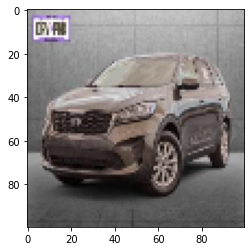

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/sv_27.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

In [ ]:
#  creating an object for test case
vt_img = cv2.imread(path)
vt_img = cv2.resize(vt_img, (100,100))
vt_img_tensor = transforms.ToTensor()(vt_img)

In [ ]:
#  creating object for background data
images, _ = next(iter(test_dl))

In [ ]:
#  instantiating explainer and deriving shap values
explainer = shap.DeepExplainer(model_100, images[:100])
shap_values = explainer.shap_values(vt_img_tensor.view(-1,3,100,100))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
#  confirming predictions
torch.argmax(model_75(vt_img_tensor))

tensor(1)

model 75x75px
sedan: 18.0%, coupe: 47.0%, suv: 17.0%, truck: 17.0%
prediction: coupe
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 18.0%, coupe: 47.0%, suv: 17.0%, truck: 17.0%
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe


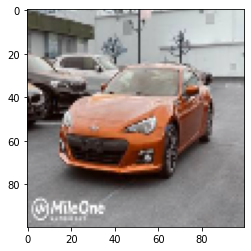

In [ ]:
#  performing visual test
visual_test(path, model_75, model_100)

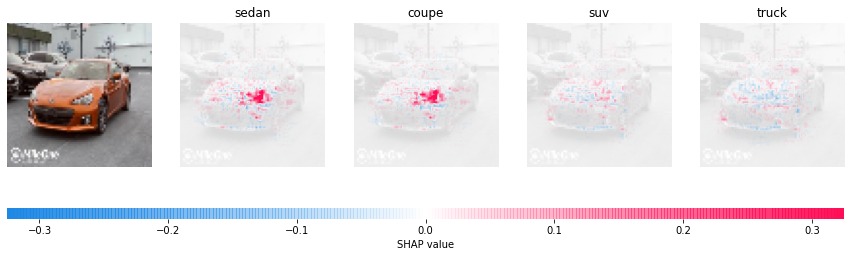

In [ ]:
#  model_75
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

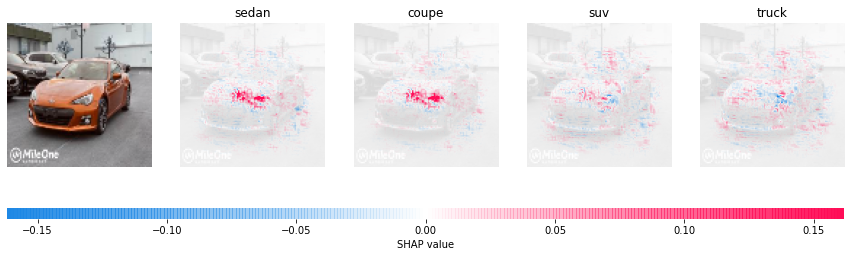

In [ ]:
#  model_100
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

model 75x75px
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
highest confidence
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv


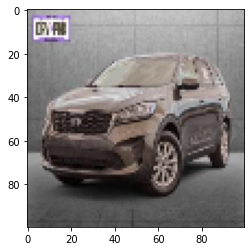

In [ ]:
#  performing visual test
visual_test(path, model_75, model_100)

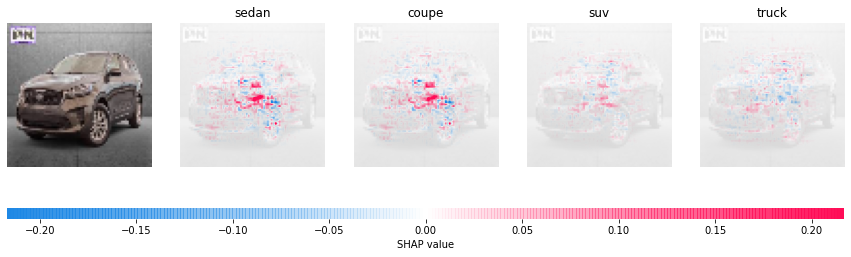

In [ ]:
#  model_75
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

In [ ]:
#  model_100
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

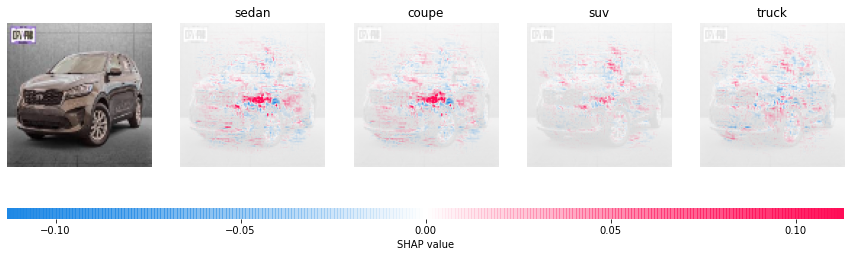

In [ ]:
shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

In [ ]:
a = torch.tensor([1,2,3,4])
b = torch.tensor([5,6,7,8])
c = np.array(([a.numpy()],[b.numpy()]))

torch.concat((a,b), dim=0)[4]

tensor(5)

In [ ]:
c = c.reshape(2,4)
np.argmax(c.mean(axis=0))

3

In [ ]:
def extract_results(network, dataloader, file_name):
  #  creating an empty list
  results = []
  labels = []
  #  classification
  with torch.no_grad():
    for img, lb in tqdm(dataloader):
      img, lb = img.to(device), lb.to(device)
      preds = network(img)
      results.extend(torch.argmax(preds, dim=1).tolist())
      labels.extend(lb.tolist())
  df = pd.DataFrame({'predicted': results, 'labels': labels})
  df.to_csv(f'gdrive/My Drive/Neural Networks/Test_results/{file_name}', index=False)
  print('Done!')
  return df.head()

In [ ]:
#  extracting test results
extract_results(model, test_dl, 'CarType100x100_results.csv')

100%|██████████| 41/41 [00:08<00:00,  4.86it/s]


Done!


,predicted,labels
0,3,3
1,0,0
2,0,0
3,2,2
4,1,1


In [ ]:
#  loading test results
test_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType100x100_results.csv')

In [ ]:
#  total number of instances
len(test_results)

8133

In [ ]:
#  preview of test results
test_results.head()

,predicted,labels
0,3,3
1,0,0
2,0,0
3,2,2
4,1,1


In [ ]:
#  defining mapping function
def actual_label(instance):
  if instance == 0:
    instance = 'sedan'
  elif instance == 1:
    instance = 'coupe'
  elif instance == 2:
    instance = 'suv'
  elif instance == 3:
    instance = 'truck'
  return instance

In [ ]:
#  converting numerical labels into strings
test_results['predicted'] = test_results['predicted'].map(actual_label)
test_results['labels'] = test_results['labels'].map(actual_label) 

In [ ]:
#  previewing converted labels
test_results.head()

,predicted,labels
0,truck,truck
1,sedan,sedan
2,sedan,sedan
3,suv,suv
4,coupe,coupe


In [ ]:
#  filtering out misclassified instances
misclassified = test_results[test_results['predicted']!=test_results['labels']]
misclassified.head()

,predicted,labels
8,coupe,sedan
11,coupe,sedan
51,sedan,coupe
63,coupe,sedan
77,coupe,sedan


In [ ]:
#  number of misclassified instances
len(misclassified)

330

In [ ]:
#  distribution of misclassified instances by true class
misclassified['labels'].value_counts()

sedan    147
coupe     88
suv       55
truck     40
Name: labels, dtype: int64

In [ ]:
#  distribution of misclassified sedans by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='sedan']
misclassified_sedan['predicted'].value_counts()

coupe    105
suv       40
truck      2
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified suvs by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='suv']
misclassified_sedan['predicted'].value_counts()

sedan    24
truck    20
coupe    11
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified coupes by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='coupe']
misclassified_sedan['predicted'].value_counts()

sedan    69
suv      14
truck     5
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified trucks by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='truck']
misclassified_sedan['predicted'].value_counts()

suv      26
coupe    11
sedan     3
Name: predicted, dtype: int64